In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from scipy.interpolate import interp1d
import lmfit as lm
import scipy.cluster.hierarchy as ch

In [11]:
egfp=np.array(pd.read_excel('20170316_K3_gfp_timecorr.xlsx', index_col=None,header=None)).T
time = np.array(egfp[0]/60/60)
egfp = egfp[1:]
print(egfp.shape)

(174, 73)


In [12]:
def twostage(t,t0,ktl,delta,beta,off=0):
    km=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    t0=np.abs(t0)
    return off+(ktl/(delta-beta)*(1-np.exp(-(delta-beta)*(t-t0)))*np.exp(-beta*(t-t0))).clip(0)
twostage_model = lm.Model(twostage)

In [13]:
def threestage(t,t0,ktl,km,delta,beta,off=0):
    km=np.abs(km)
    ktl=np.abs(ktl)
    delta=np.abs(delta)
    beta=np.abs(beta)
    dmb = delta-beta
    bkm = beta + km
    dmbk = delta-bkm
    t0=np.abs(t0)
    dt=t-t0
    result = 1/dmb +km*np.exp(-dmb*dt)/dmb/dmbk-np.exp(-km*dt)/dmbk
    result = ktl*np.exp(-beta*dt)*result.clip(0)
    result[t<t0]=0
    return off+result
threestage_model = lm.Model(threestage)

[[Model]]
    Model(twostage)
[[Fit Statistics]]
    # function evals   = 44
    # data points      = 73
    # variables        = 5
    chi-square         = 11286.882
    reduced chi-square = 165.984
    Akaike info crit   = 383.168
    Bayesian info crit = 394.620
[[Variables]]
    t0:     -0.06811039 +/- 0        (0.00%) (init= 4)
    ktl:    -34.3415088 +/- 0        (0.00%) (init= 800)
    delta:  -1.36642767 +/- 0        (0.00%) (init= 0.07)
    beta:    5.96959184 +/- 0        (0.00%) (init= 0.05)
    off:     20.8137158 +/- 0        (0.00%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)

[[Model]]
    Model(threestage)
[[Fit Statistics]]
    # function evals   = 166
    # data points      = 73
    # variables        = 6
    chi-square         = 643.873
    reduced chi-square = 9.610
    Akaike info crit   = 177.185
    Bayesian info crit = 190.928
[[Variables]]
    t0:      7.13367862 +/- 0.209997 (2.94%) (init= 4)
    ktl:     1389.42058 +/- 1.21e+04 (868.10%)

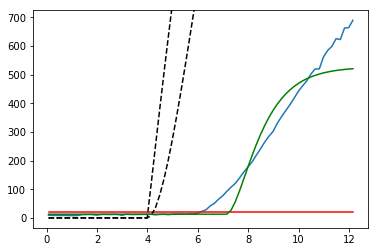

In [14]:
data = egfp[50]
sigma = np.sqrt(data)
result2 = twostage_model.fit(data, t=time, t0=4, ktl=800, delta=0.07, beta=0.05, weights=1/sigma)
result3 = threestage_model.fit(data, t=time, t0=4, ktl=800, km=1,delta=0.07, beta=0.05, weights=1/sigma)
plt.figure()
plt.plot(time,data)
plt.plot(time,result2.init_fit, 'k--')
plt.plot(time, result2.best_fit, 'r-')
plt.plot(time,result3.init_fit, 'k--')
plt.plot(time, result3.best_fit, 'g-')
plt.ylim((-0.05*data.max(),data.max()*1.05))
print(result2.fit_report())
print(result3.fit_report())

In [15]:
# cluster analysis to find the onset for fluorescence
# normalize the data
time_norm=(time-time.min())/50/(time.max()-time.min())
t0cluster_list=[]
for data in egfp:
    data_norm=(data-data.min())/(data.max()-data.min())
    data_diff_norm=np.gradient(data_norm)
    # combine the data
    X = np.vstack((time_norm,data_norm,data_diff_norm)).T
    # generate the linkage matrix
    Z = ch.linkage(X, method='single',metric='cityblock')
    tree = ch.cut_tree(Z, height=0.003).flatten()
    t0cluster_list.append(tree[tree==0].size)
t0cluster_list=np.array(t0cluster_list)
# convert to hours
t0cluster_list=(t0cluster_list)*10/60

data set 0 t0_guess 7.1468363759296825
data set 1 t0_guess 3.574940912795436
data set 2 t0_guess 2.710503924866835
data set 3 t0_guess 5.202819178852644
data set 4 t0_guess 4.625474537037038
data set 5 t0_guess 4.48692474566128
data set 6 t0_guess 4.387113044242344
data set 7 t0_guess 2.5576273753215504
data set 8 t0_guess 2.4775177521414475
data set 9 t0_guess 3.423437738149673
data set 10 t0_guess 5.610371252054639
data set 11 t0_guess 6.1353630490956075
data set 12 t0_guess 2.9717512668153727
data set 13 t0_guess 2.843999454846229
data set 14 t0_guess 3.026396578005567
data set 15 t0_guess 3.9951003595489927
data set 16 t0_guess 3.6270939246439515
data set 17 t0_guess 5.010440398273221
data set 18 t0_guess 3.0781255223132207
data set 19 t0_guess 2.6924083830215904
data set 20 t0_guess 3.1647524866990513


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


data set 21 t0_guess 2.732894318163918
data set 22 t0_guess 2.980913614882354
data set 23 t0_guess 2.6445486959367415
data set 24 t0_guess 2.581240807090326
data set 25 t0_guess 3.236116117850953
data set 26 t0_guess 3.1188997589182765
data set 27 t0_guess 2.3503347758436255
data set 28 t0_guess 3.4182756426571643
data set 29 t0_guess 3.3927488977750437
data set 30 t0_guess 2.5983796972762354
data set 31 t0_guess 3.582146635216754
data set 32 t0_guess 3.5711897262404726
data set 33 t0_guess 4.19649728588661
data set 34 t0_guess 2.708379213646282
data set 35 t0_guess 4.474162211255055
data set 36 t0_guess 4.416368590689893
data set 37 t0_guess 4.0592207875223725
data set 38 t0_guess 4.3908576051779935
data set 39 t0_guess 4.55480938697318
data set 40 t0_guess 2.510673961898835
data set 41 t0_guess 4.696790335903084
data set 42 t0_guess 3.87780067037011
data set 43 t0_guess 2.818415087451462
data set 44 t0_guess 3.826788945952556
data set 45 t0_guess 2.9811482507438187
data set 46 t0_gue

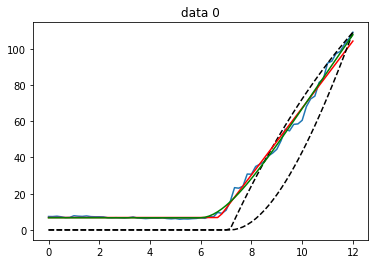

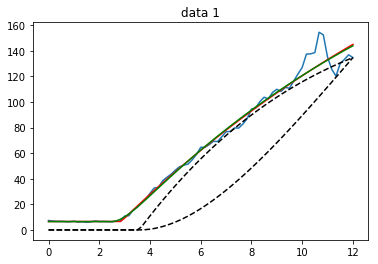

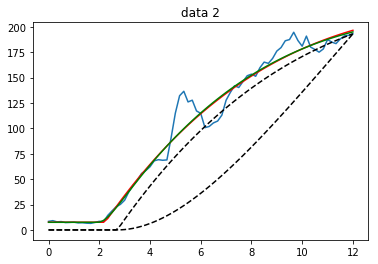

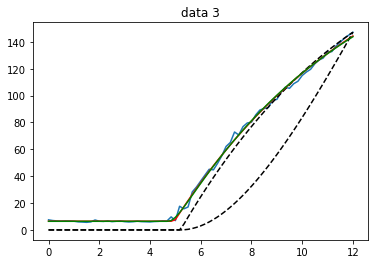

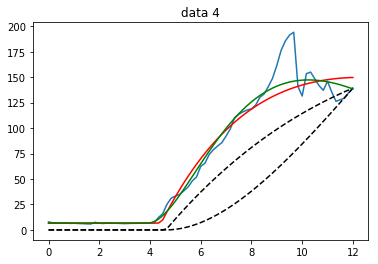

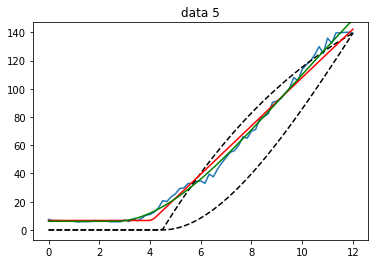

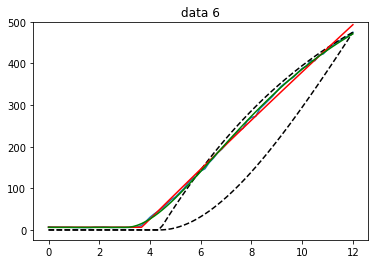

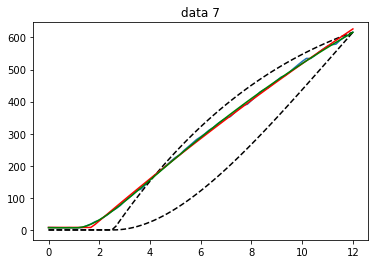

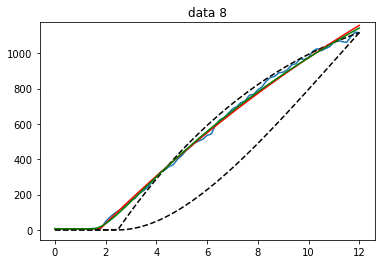

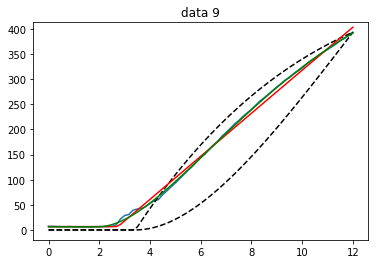

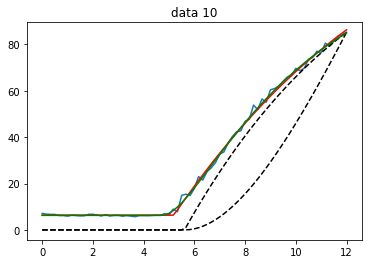

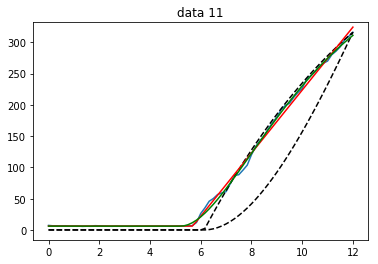

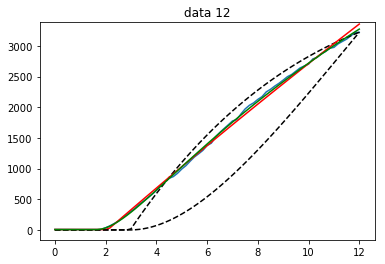

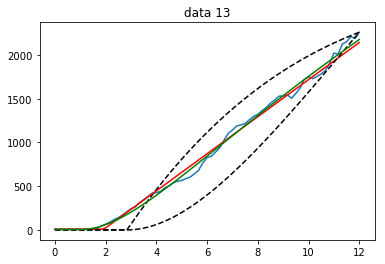

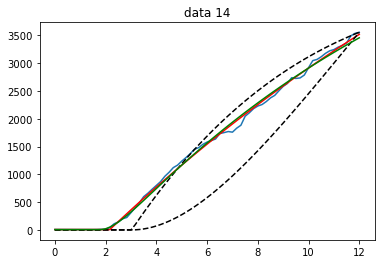

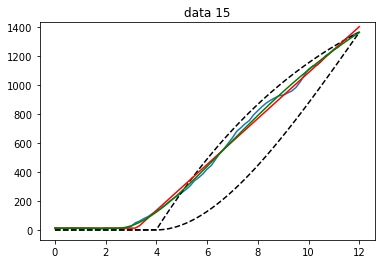

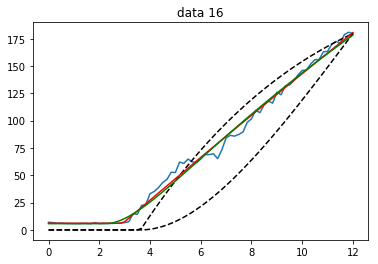

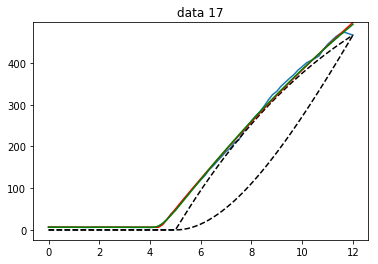

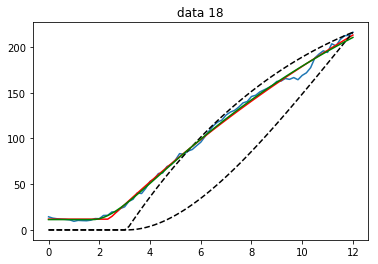

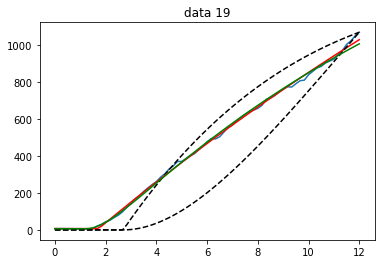

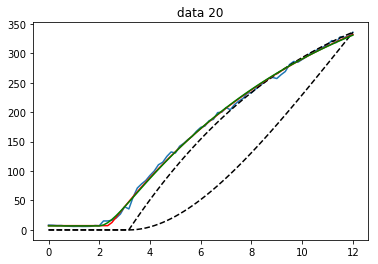

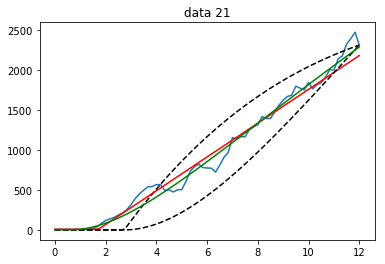

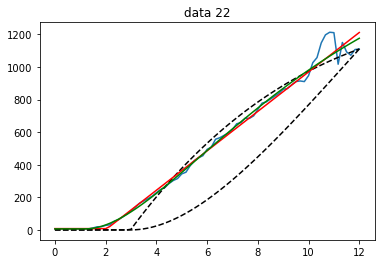

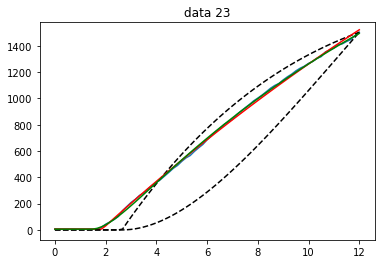

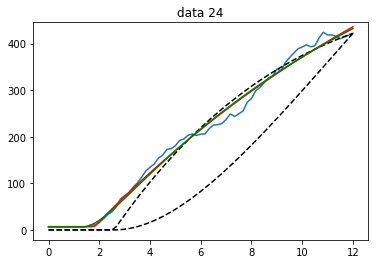

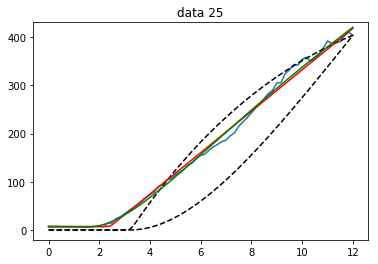

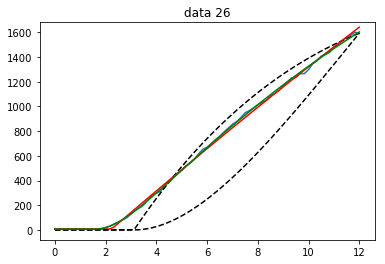

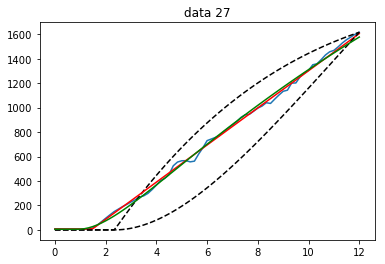

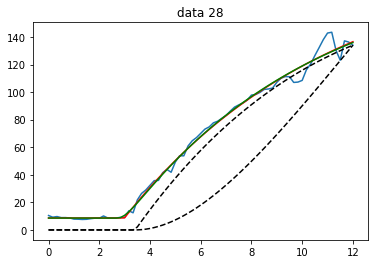

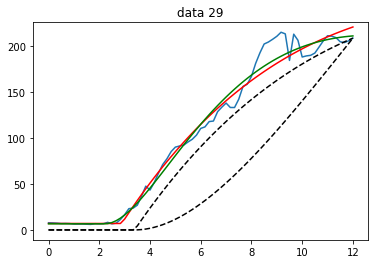

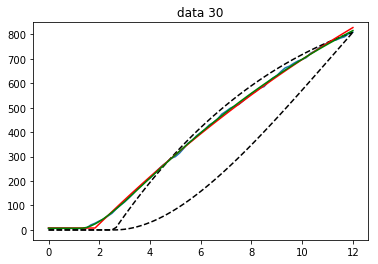

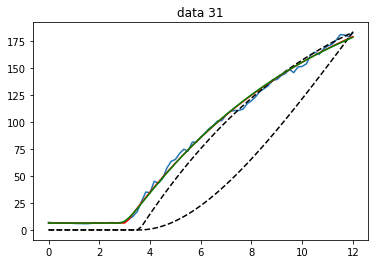

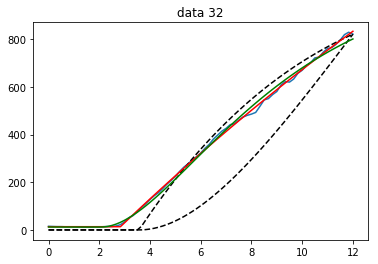

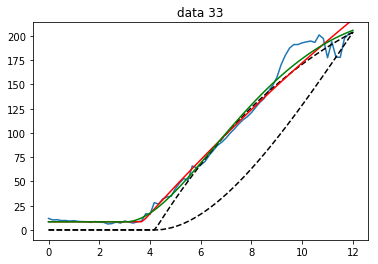

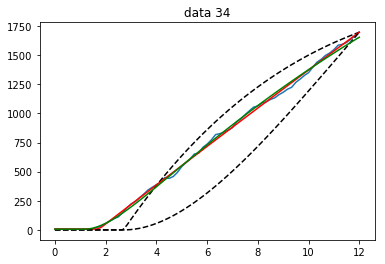

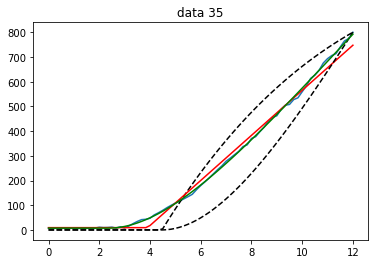

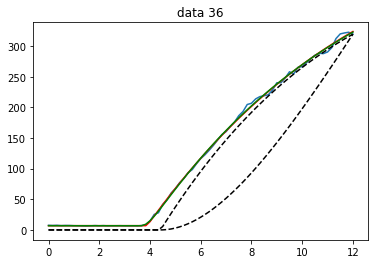

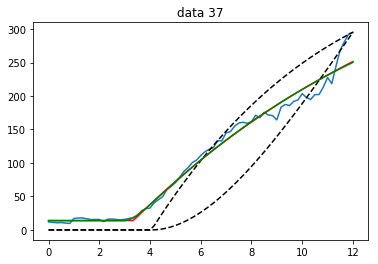

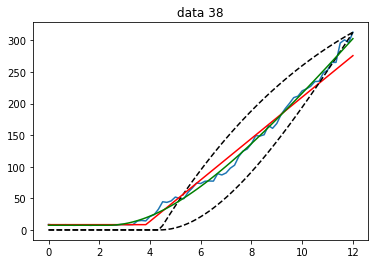

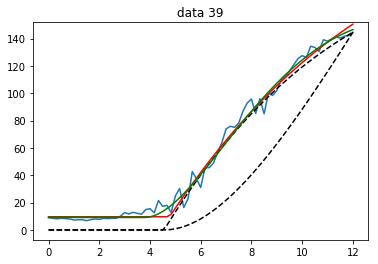

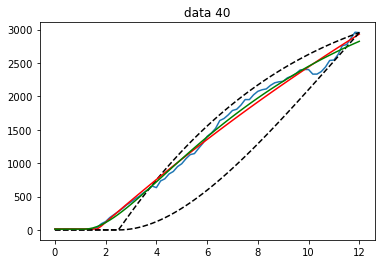

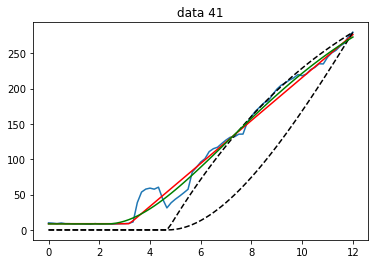

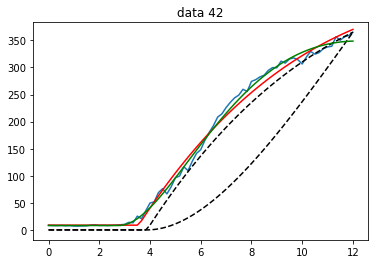

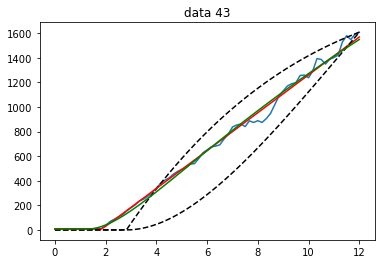

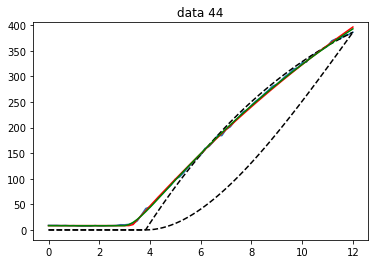

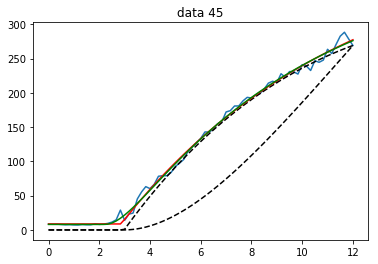

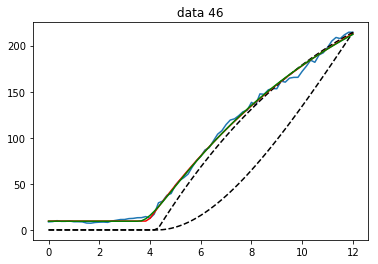

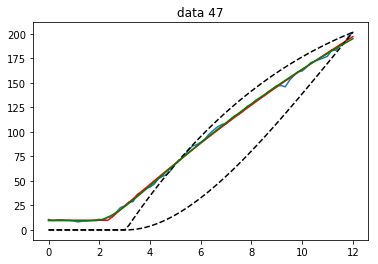

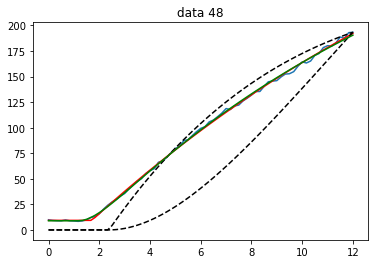

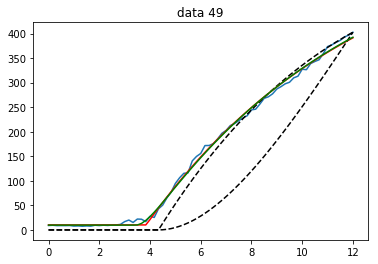

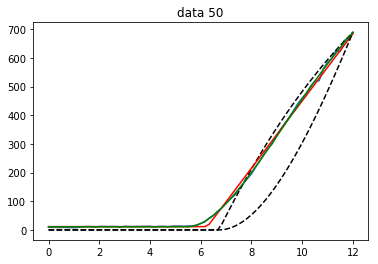

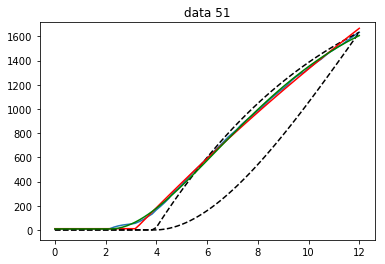

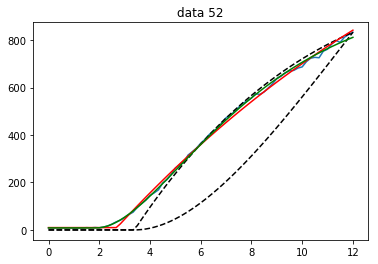

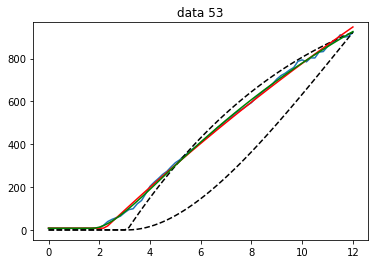

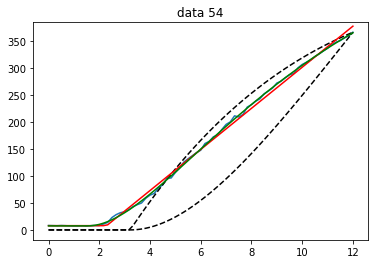

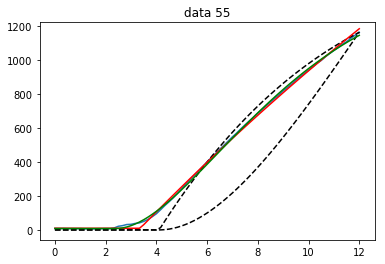

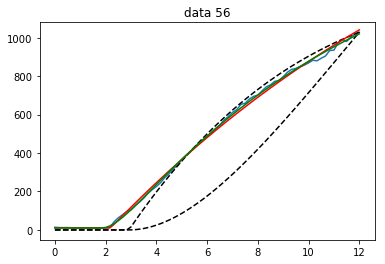

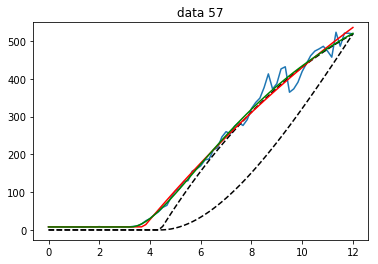

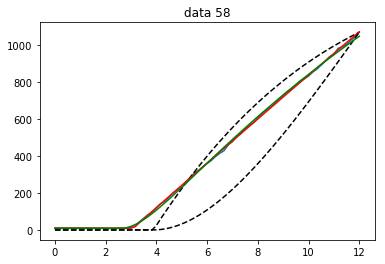

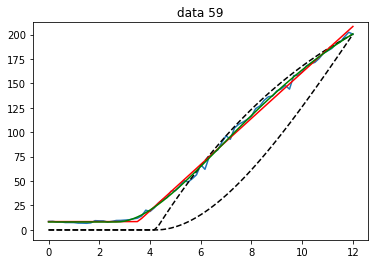

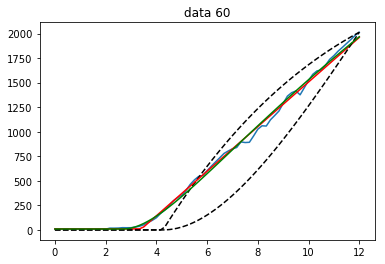

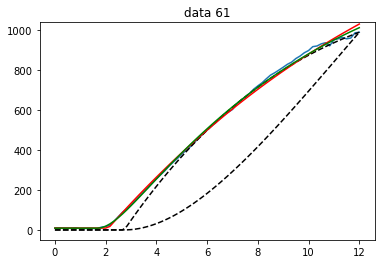

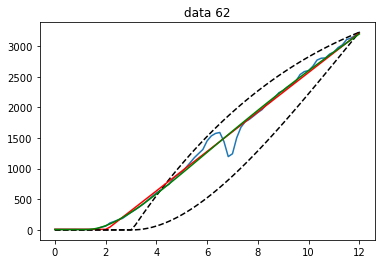

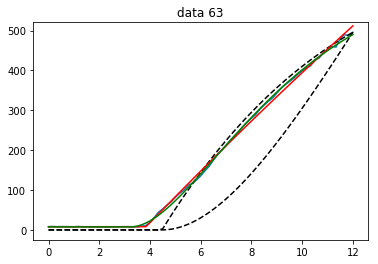

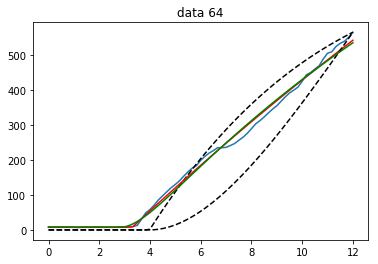

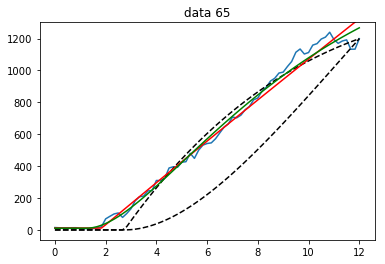

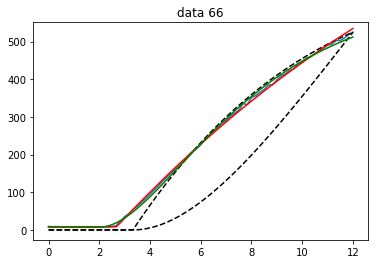

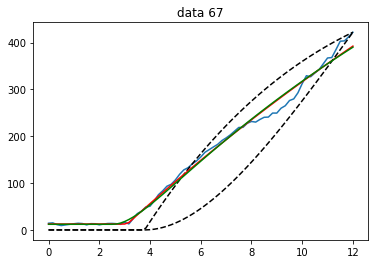

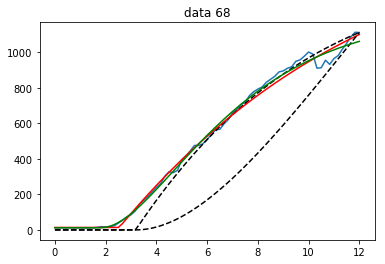

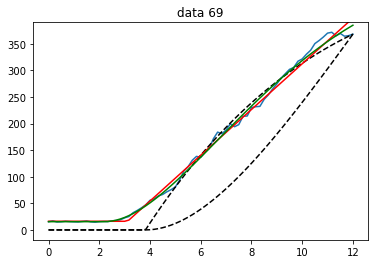

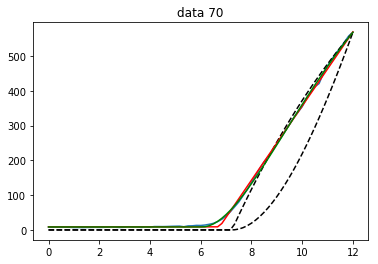

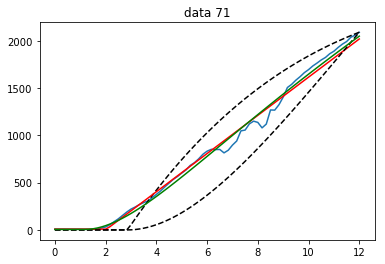

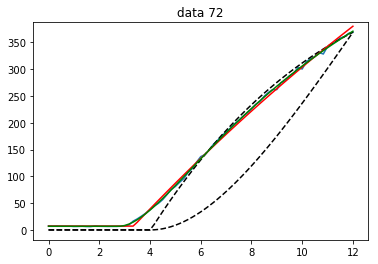

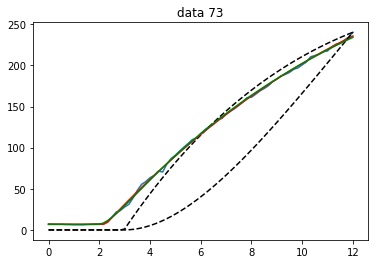

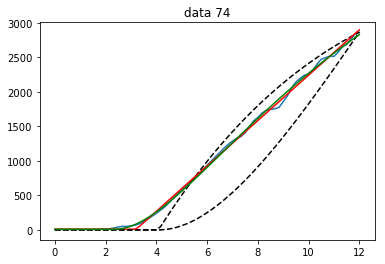

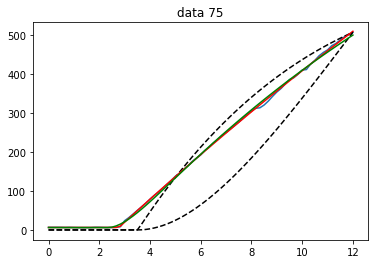

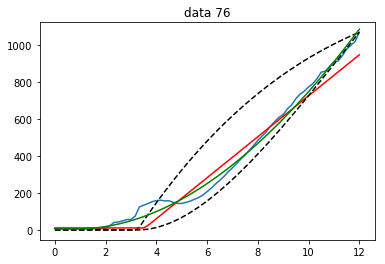

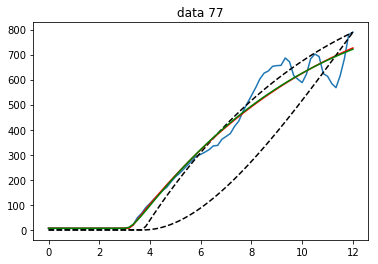

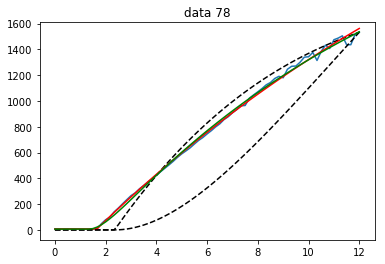

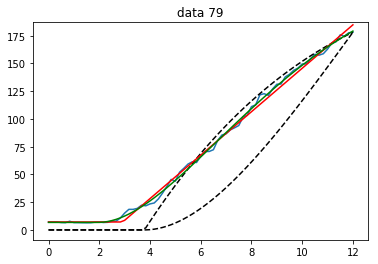

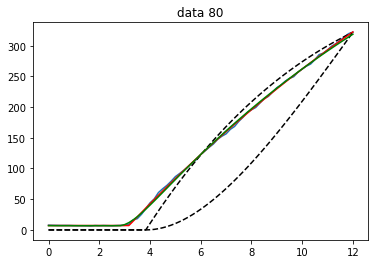

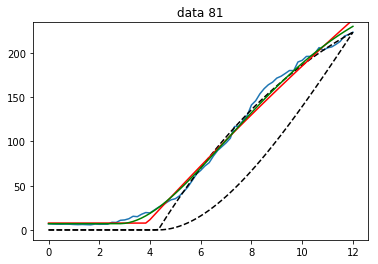

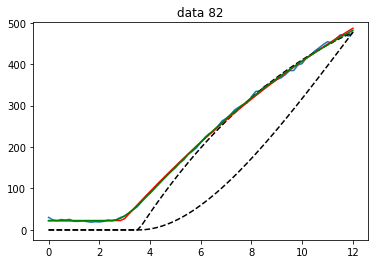

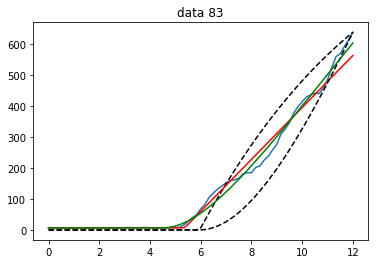

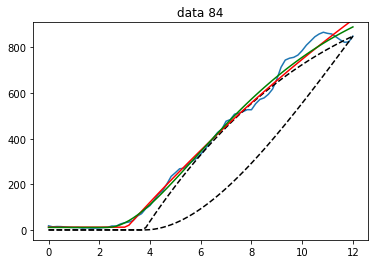

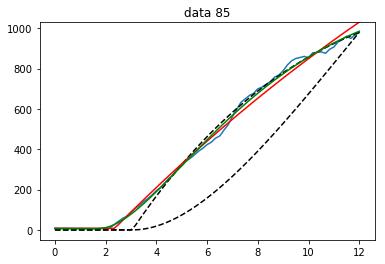

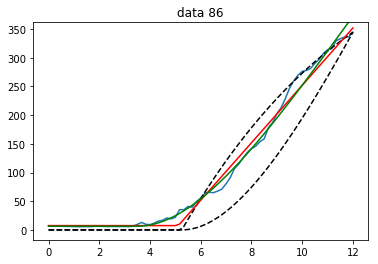

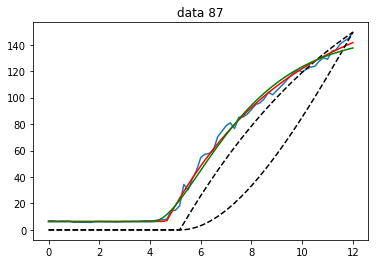

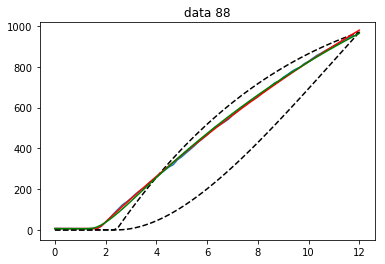

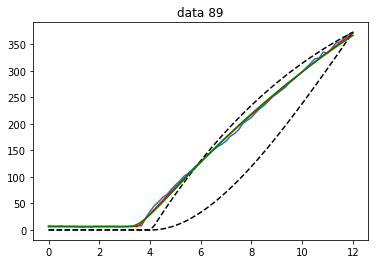

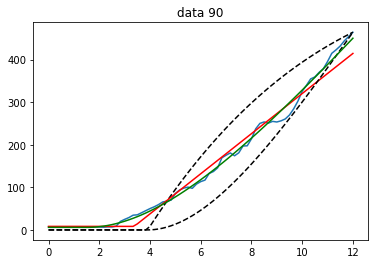

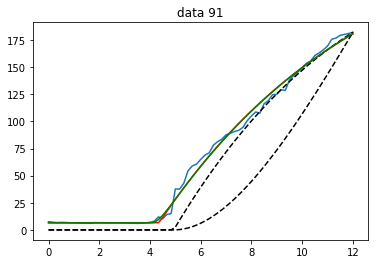

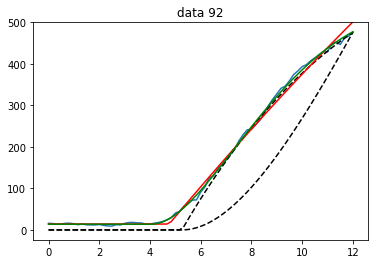

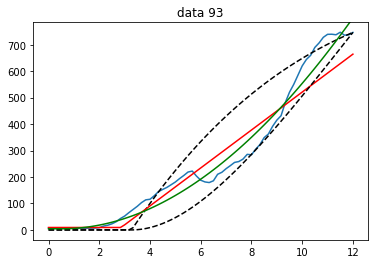

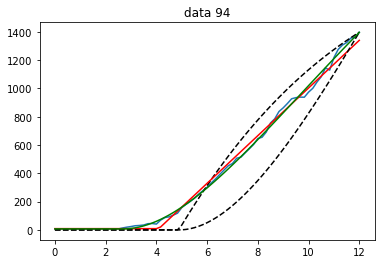

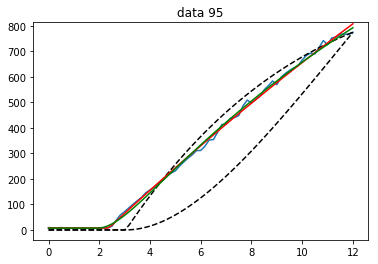

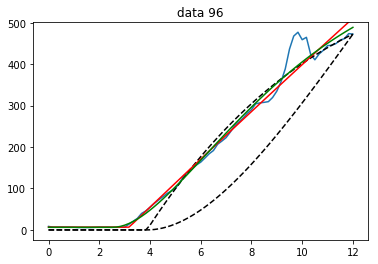

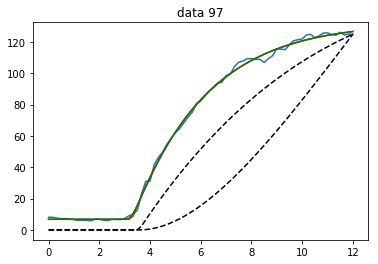

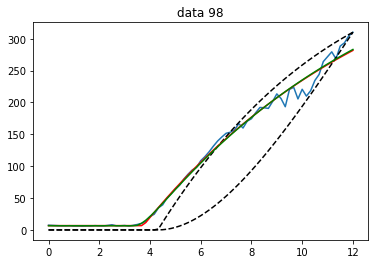

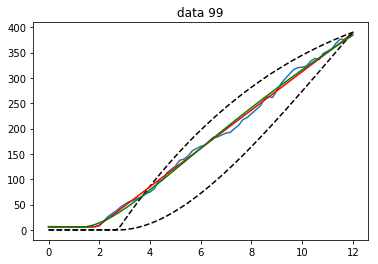

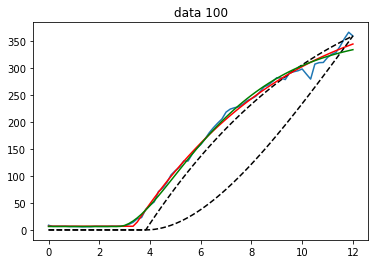

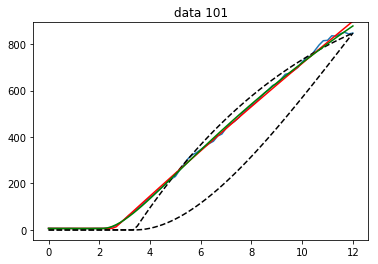

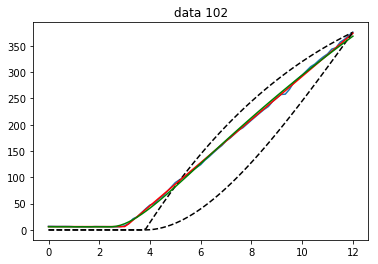

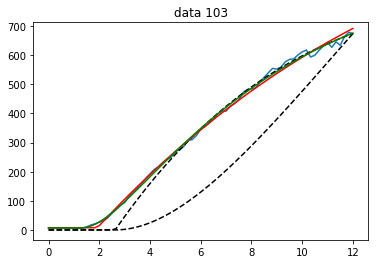

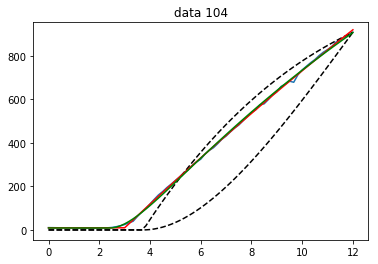

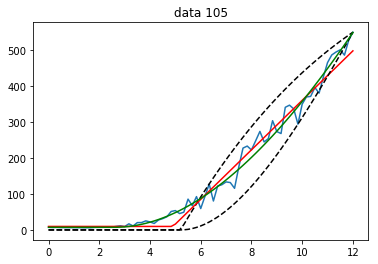

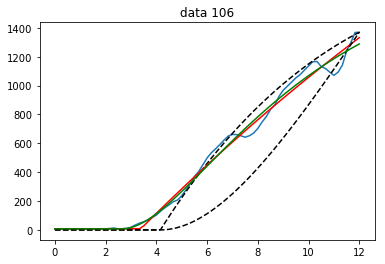

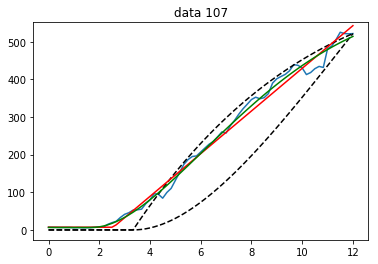

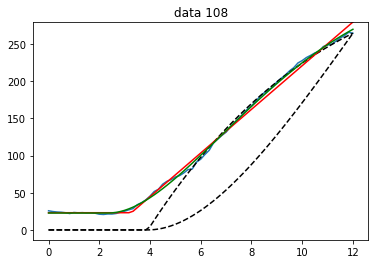

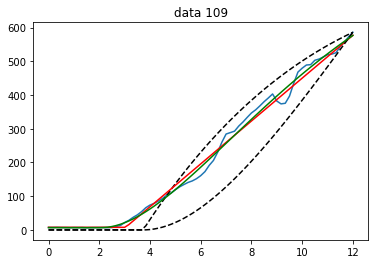

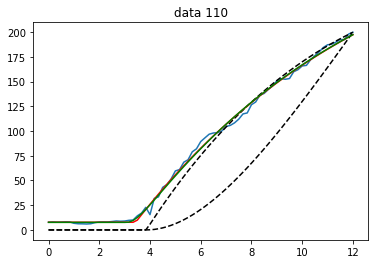

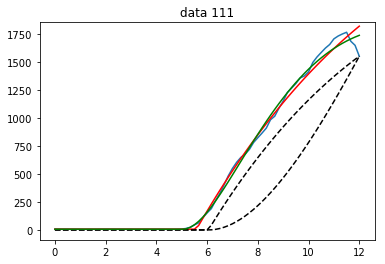

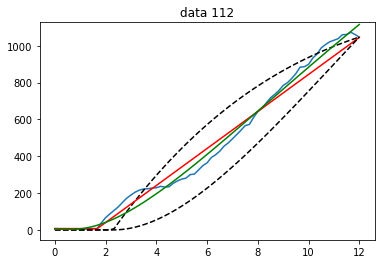

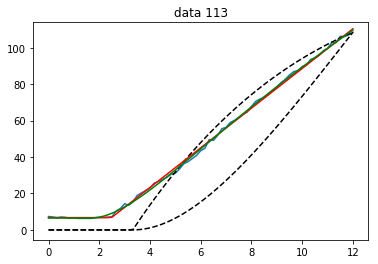

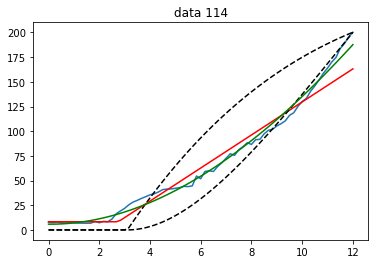

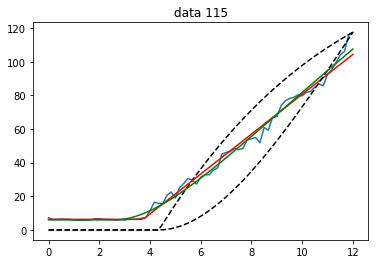

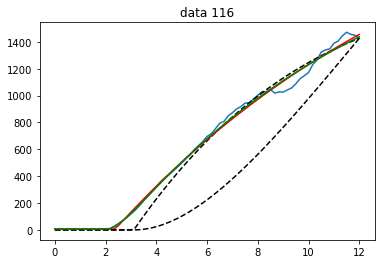

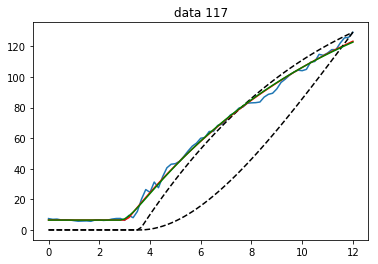

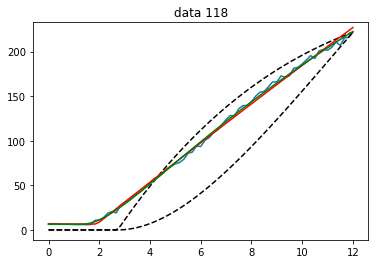

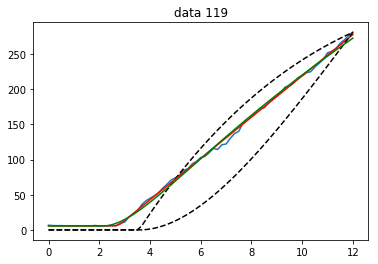

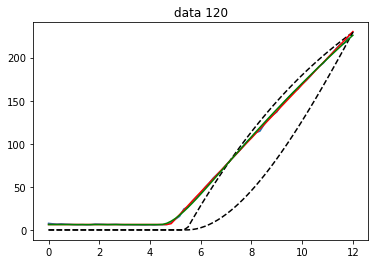

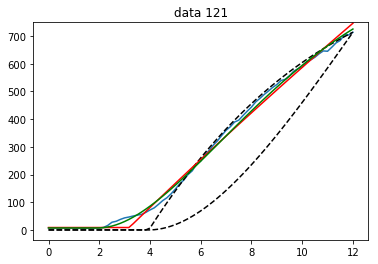

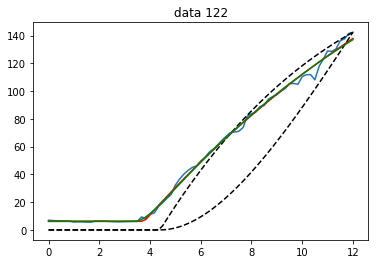

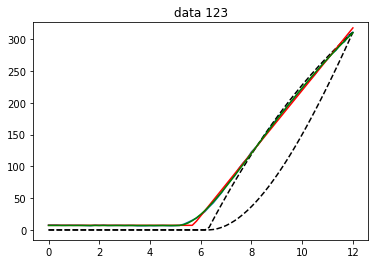

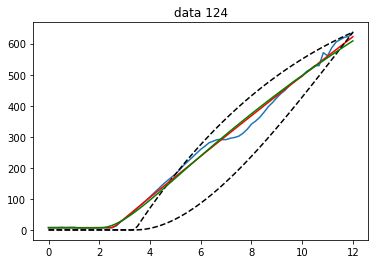

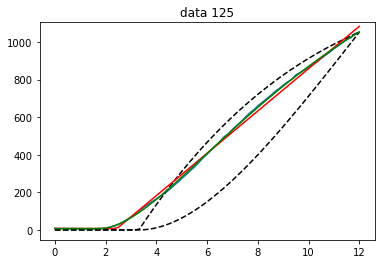

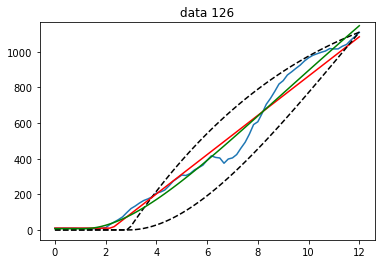

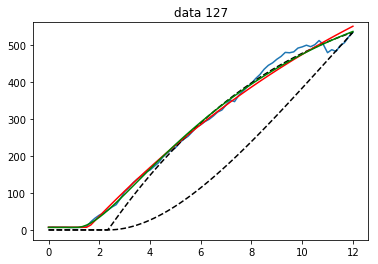

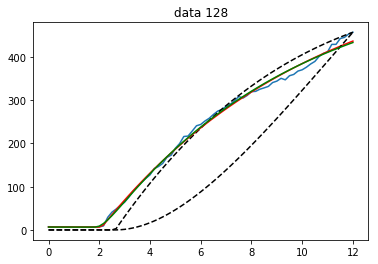

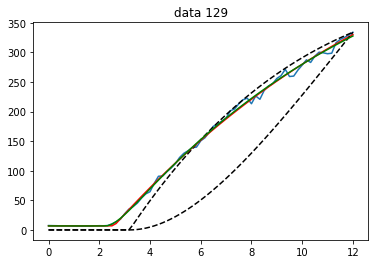

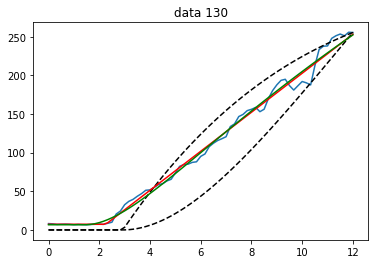

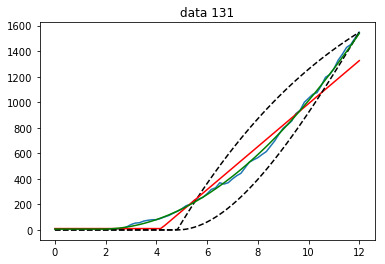

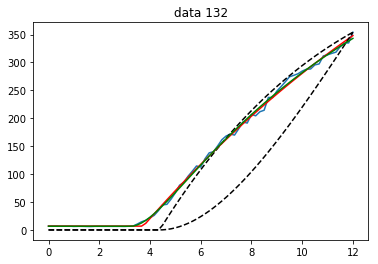

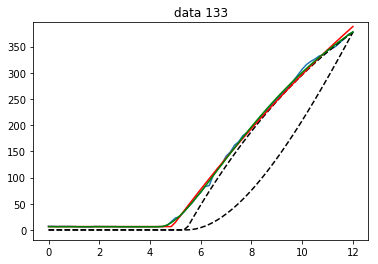

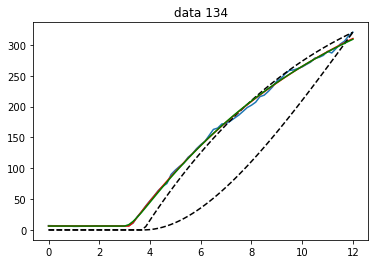

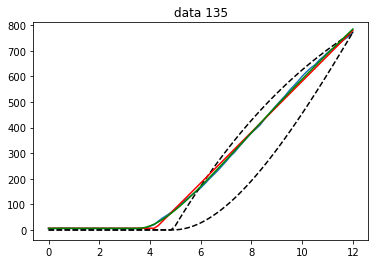

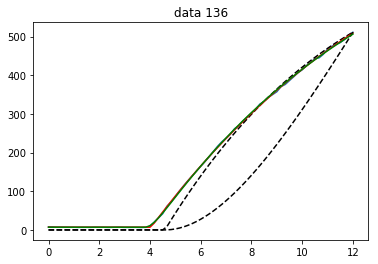

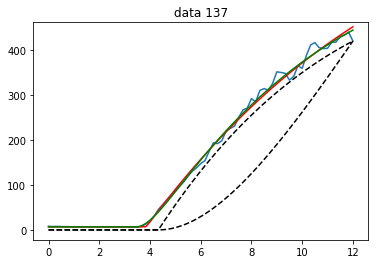

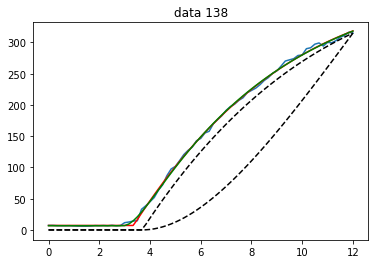

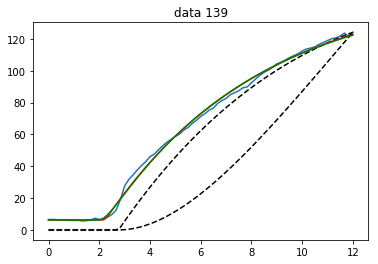

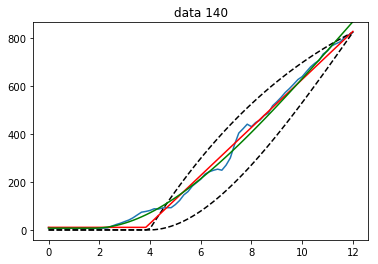

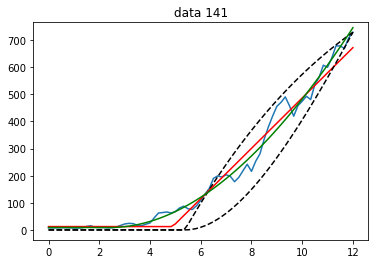

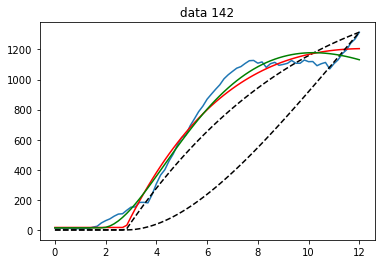

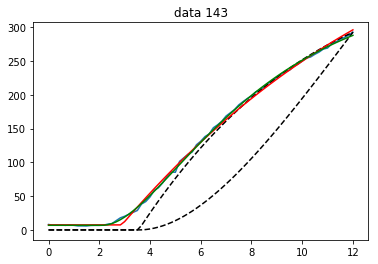

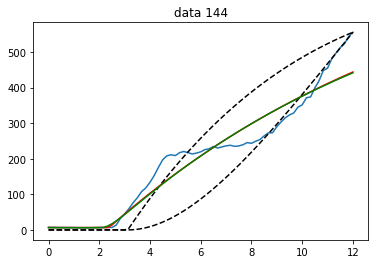

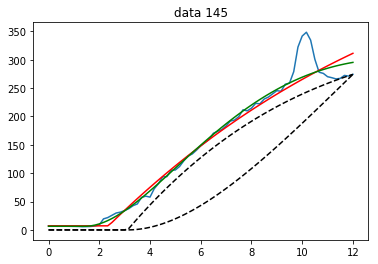

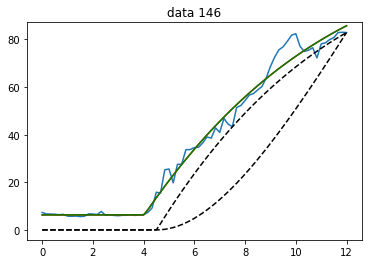

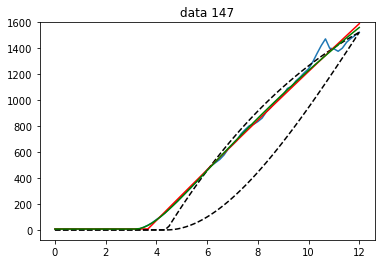

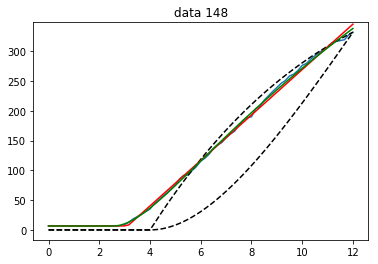

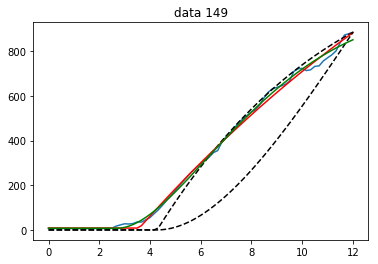

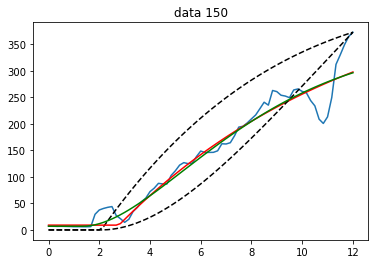

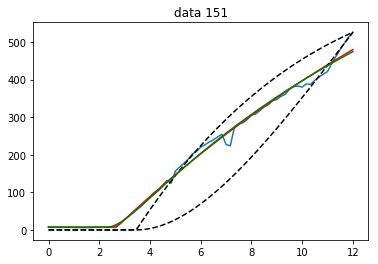

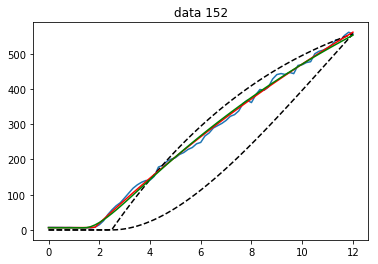

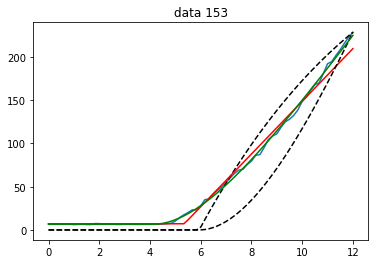

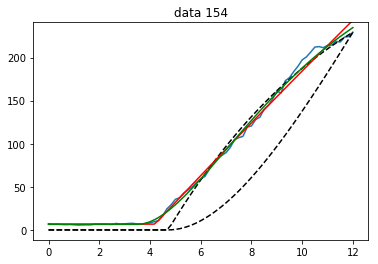

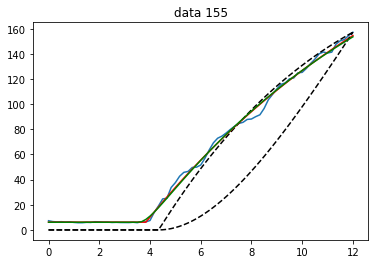

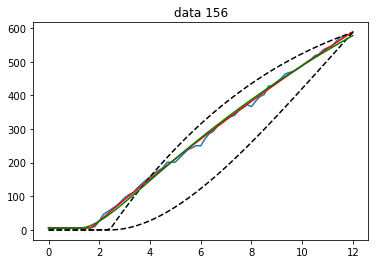

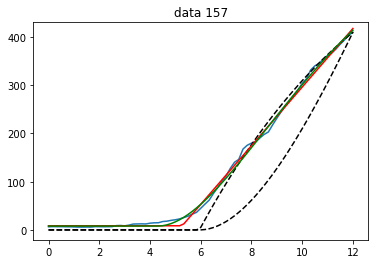

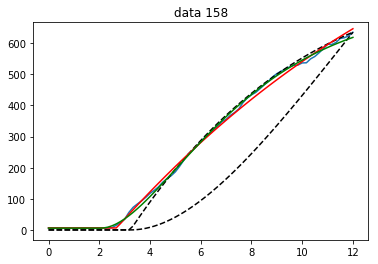

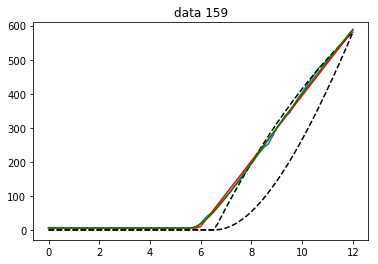

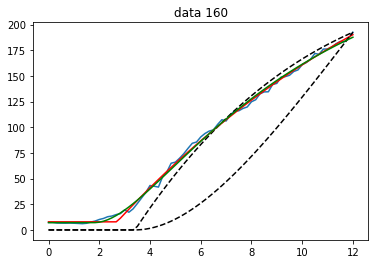

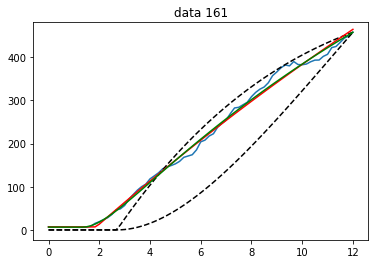

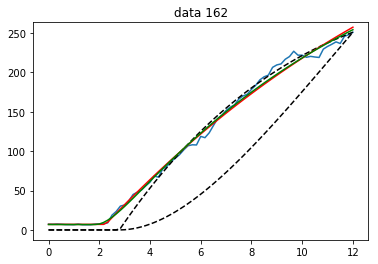

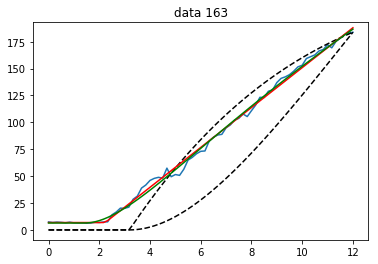

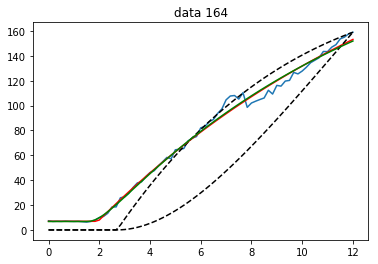

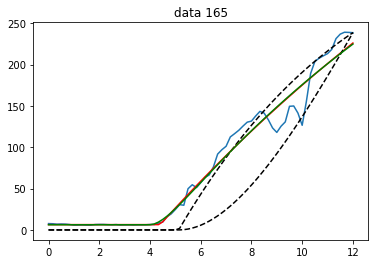

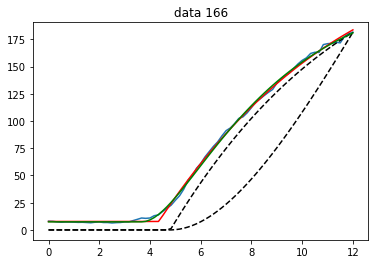

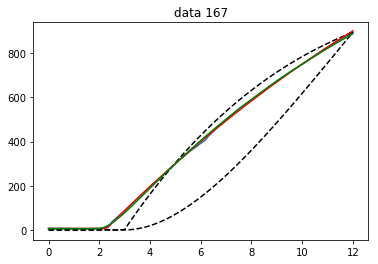

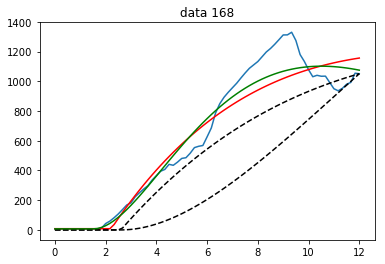

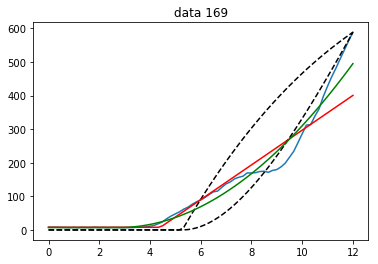

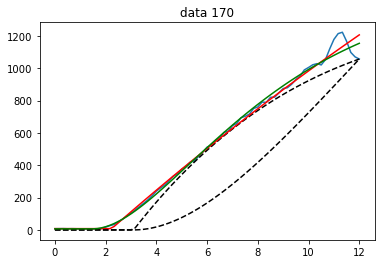

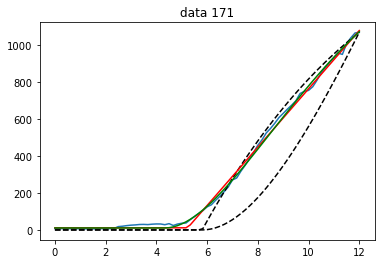

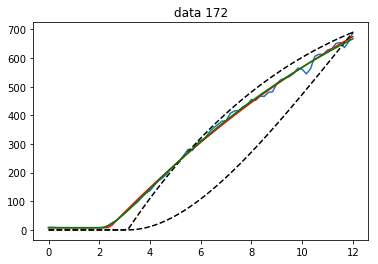

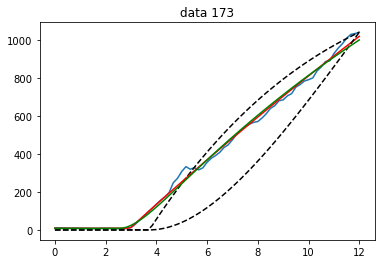

In [16]:
# two stage model
t0_list=[]
ktl_list=[]
delta_list=[]
beta_list=[]
t0_std_list=[]
ktl_std_list=[]
delta_std_list=[]
beta_std_list=[]
red_chi2_list=[]

# three stage model
t0_list3=[]
ktl_list3=[]
km_list3=[]
delta_list3=[]
beta_list3=[]
t0_std_list3=[]
ktl_std_list3=[]
km_std_list3=[]
delta_std_list3=[]
beta_std_list3=[]
red_chi2_list3=[]

for data,i in zip(egfp,range(t0cluster_list.size)):
    sigma = np.sqrt(data)
    time = np.arange(0,data.size)*10/60
    # lets estimate the parameters
    # to estimate t0 we take I_max-I_min and estimate t for which I=I_min+0.1(I_max-Imin)
    # this can be done by interpolation.  The advantage is that the guess for t0 is greater
    # than the actual value - fits seems to converge better
    delta_I=data.max()-data.min()
    t0guess = interp1d(data,time)(data.min()+0.09*delta_I)
    print("data set",i,"t0_guess",t0guess)
    delta_t=time[-1]-t0guess
    
    two=twostage(np.array([delta_t]),0,1,0.07,0.05)
    ktl2=data[-1]/two[0]
    
    three=threestage(np.array([delta_t]),0,1,0.03,0.07,0.05)
    ktl3=data[-1]/three[0]
    
    result2 = twostage_model.fit(data, t=time, t0=t0guess, ktl=ktl2, delta=0.07, beta=0.05, weights=1/sigma)
    result3 = threestage_model.fit(data, t=time, t0=t0guess, ktl=ktl3, km=0.03,delta=0.07, beta=0.05, weights=1/sigma)

    plt.figure()
    plt.title("data "+str(i))
    plt.plot(time,data)
    plt.plot(time,result2.init_fit, 'k--')
    plt.plot(time, result2.best_fit, 'r-')
    plt.plot(time,result3.init_fit, 'k--')
    plt.plot(time, result3.best_fit, 'g-')
    plt.ylim((-0.05*data.max(),data.max()*1.05))
    
    if result2:
        t0_list.append(np.abs(result2.values['t0']))
        ktl_list.append(np.abs(result2.values['ktl']))
        delta_list.append(np.abs(result2.values['delta']))
        beta_list.append(np.abs(result2.values['beta']))
        red_chi2_list.append(result2.redchi)

        t0_std_list.append(result2.covar[0][0])
        ktl_std_list.append(result2.covar[1][1])
        delta_std_list.append(result2.covar[2][2])
        beta_std_list.append(result2.covar[3][3])
    
    if result3:
        t0_list3.append(np.abs(result3.values['t0']))
        ktl_list3.append(np.abs(result3.values['ktl']))
        km_list3.append(np.abs(result3.values['km']))
        delta_list3.append(np.abs(result3.values['delta']))
        beta_list3.append(np.abs(result3.values['beta']))
        red_chi2_list3.append(result3.redchi)

        t0_std_list3.append(result3.covar[0][0])
        ktl_std_list3.append(result3.covar[1][1])
        km_std_list3.append(result3.covar[2][2])
        delta_std_list3.append(result3.covar[3][3])
        beta_std_list3.append(result3.covar[4][4])
    
t0_list=np.array(t0_list)
ktl_list=np.array(ktl_list)
delta_list=np.array(delta_list)
beta_list=np.array(beta_list)
t0_std_list=np.array(t0_std_list)
ktl_std_list=np.array(ktl_std_list)
delta_std_list=np.array(delta_std_list)
beta_std_list=np.array(beta_std_list)

t0_list3=np.array(t0_list3)
ktl_list3=np.array(ktl_list3)
km_list3=np.array(km_list3)
delta_list3=np.array(delta_list3)
beta_list3=np.array(beta_list3)
t0_std_list3=np.array(t0_std_list3)
ktl_std_list3=np.array(ktl_std_list3)
km_std_list3=np.array(km_std_list3)
delta_std_list3=np.array(delta_std_list3)
beta_std_list3=np.array(beta_std_list3)

red_chi2_list=np.array(red_chi2_list)
red_chi2_list3=np.array(red_chi2_list3)


1.59767956079 1.03269090677
2.90712145259 1.81011263323
[ 12.70737312   6.65833624   1.51971933   0.50031646   0.19983808
   0.0400066 ]
[ 6.74046491  4.41067643  0.93392923  0.37305106  0.1515299   0.03812629]


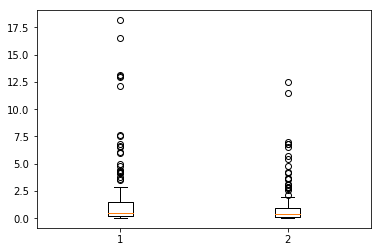

In [17]:
plt.boxplot([red_chi2_list,red_chi2_list3])
print(red_chi2_list.mean(),red_chi2_list3.mean())
print(red_chi2_list.std(),red_chi2_list3.std())
print(np.percentile(red_chi2_list,[97.5,95,75,50,25,2.5]))
print(np.percentile(red_chi2_list3,[97.5,95,75,50,25,2.5]))

In [18]:
print(np.argmax(red_chi2_list),red_chi2_list.max())
print(np.argmax(red_chi2_list3),red_chi2_list3.max())

168 18.1609006629
21 12.4558672279


In [19]:
# cleaning up the data by setting a threshold for redchi2
threshold2 = 150
threshold3 = 150
ktl_list_clean=ktl_list[red_chi2_list<threshold2]
delta_list_clean=delta_list[red_chi2_list<threshold2]
beta_list_clean=beta_list[red_chi2_list<threshold2]
t0_list_clean=t0_list[red_chi2_list<threshold2]
ktl_std_list_clean=ktl_std_list[red_chi2_list<threshold2]
delta_std_list_clean=delta_std_list[red_chi2_list<threshold2]
beta_std_list_clean=beta_std_list[red_chi2_list<threshold2]
t0_std_list_clean=t0_std_list[red_chi2_list<threshold2]

ktl_list3_clean=ktl_list3[red_chi2_list3<threshold3]
km_list3_clean=km_list3[red_chi2_list3<threshold3]
delta_list3_clean=delta_list3[red_chi2_list3<threshold3]
beta_list3_clean=beta_list3[red_chi2_list3<threshold3]
t0_list3_clean=t0_list3[red_chi2_list3<threshold3]
km_std_list3_clean=km_std_list3[red_chi2_list3<threshold3]
ktl_std_list3_clean=ktl_std_list3[red_chi2_list3<threshold3]
delta_std_list3_clean=delta_std_list3[red_chi2_list3<threshold3]
beta_std_list3_clean=beta_std_list3[red_chi2_list3<threshold3]
t0_std_list3_clean=t0_std_list3[red_chi2_list3<threshold3]


In [20]:
print(ktl_list.size,ktl_list_clean.size)
print(ktl_list3.size,ktl_list3_clean.size)

174 174
174 174


88.7314573987 7479.07729659


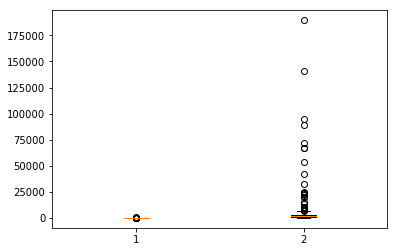

In [21]:
plt.boxplot([ktl_list_clean,ktl_list3_clean])
print(ktl_list_clean.mean(),ktl_list3_clean.mean())

(array([ 158.,    7.,    2.,    3.,    2.,    0.,    0.,    1.,    0.,    1.]),
 array([  1.21387297e+02,   1.90631059e+04,   3.80048244e+04,
          5.69465430e+04,   7.58882616e+04,   9.48299801e+04,
          1.13771699e+05,   1.32713417e+05,   1.51655136e+05,
          1.70596854e+05,   1.89538573e+05]),
 <a list of 10 Patch objects>)

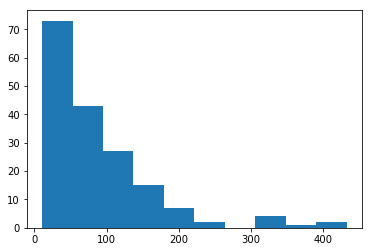

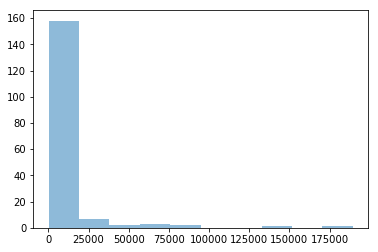

In [22]:
plt.figure()
plt.hist(ktl_list_clean)
plt.figure()
plt.hist(ktl_list3_clean,alpha=0.5)

(array([ 73.,  57.,  19.,  13.,   5.,   3.,   1.,   0.,   1.,   2.]),
 array([ 0.00245226,  0.04259836,  0.08274445,  0.12289055,  0.16303665,
         0.20318275,  0.24332884,  0.28347494,  0.32362104,  0.36376714,
         0.40391323]),
 <a list of 10 Patch objects>)

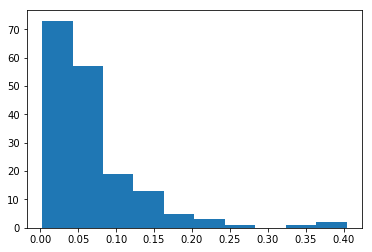

In [23]:
plt.figure()
plt.hist(km_list3_clean)

{'boxes': [<matplotlib.lines.Line2D at 0x121c72eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x121bc6940>,
 'fliers': [<matplotlib.lines.Line2D at 0x121bcab38>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x121bca320>,
 'whiskers': [<matplotlib.lines.Line2D at 0x121bc08d0>,
  <matplotlib.lines.Line2D at 0x121bd6a58>]}

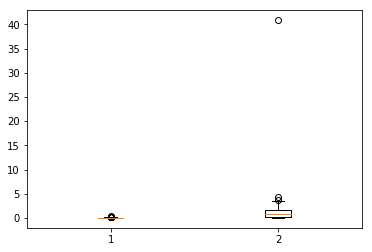

In [24]:
plt.boxplot([delta_list_clean,delta_list3_clean])

0.0314387647499 1.24087796985


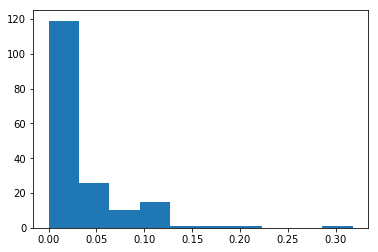

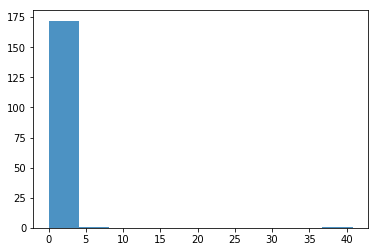

In [25]:
plt.figure()
plt.hist(delta_list_clean)
plt.figure()
plt.hist(delta_list3_clean,alpha=0.8)
print(delta_list_clean.mean(),delta_list3_clean.mean())

{'boxes': [<matplotlib.lines.Line2D at 0x1221326a0>,
 'caps': [<matplotlib.lines.Line2D at 0x12213aa58>,
 'fliers': [<matplotlib.lines.Line2D at 0x1221449b0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12213fac8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x122132f98>,
  <matplotlib.lines.Line2D at 0x12214ab70>]}

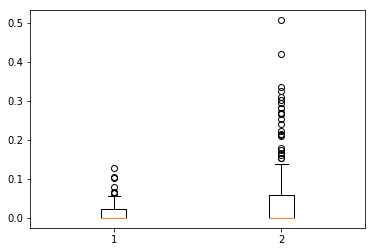

In [26]:
plt.boxplot([beta_list_clean,beta_list3_clean])

(array([ 126.,   15.,    9.,    6.,    5.,    8.,    3.,    0.,    1.,    1.]),
 array([  1.07314987e-09,   5.06678541e-02,   1.01335707e-01,
          1.52003560e-01,   2.02671413e-01,   2.53339266e-01,
          3.04007119e-01,   3.54674972e-01,   4.05342825e-01,
          4.56010678e-01,   5.06678531e-01]),
 <a list of 10 Patch objects>)

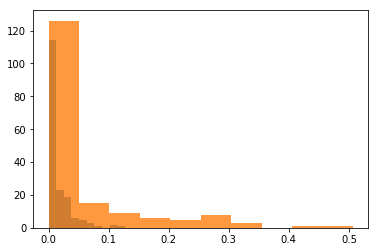

In [27]:
plt.hist(beta_list_clean)
plt.hist(beta_list3_clean,alpha=0.8)

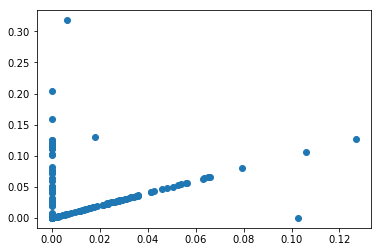

In [28]:
plt.plot(beta_list_clean,delta_list_clean,"o")

{'boxes': [<matplotlib.lines.Line2D at 0x12368f4e0>],
 'caps': [<matplotlib.lines.Line2D at 0x123697f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x1236a57f0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12369d908>],
 'whiskers': [<matplotlib.lines.Line2D at 0x12368feb8>,
  <matplotlib.lines.Line2D at 0x123697710>]}

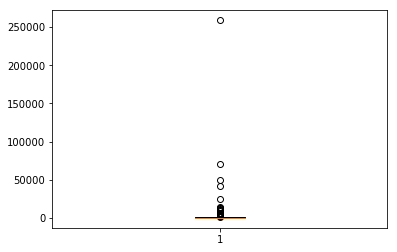

In [29]:
error_delta = delta_std_list_clean/delta_list_clean
plt.boxplot(error_delta)

{'boxes': [<matplotlib.lines.Line2D at 0x1237d95f8>,
 'caps': [<matplotlib.lines.Line2D at 0x1237e1f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x123889908>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x123882a20>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1237d9fd0>,
  <matplotlib.lines.Line2D at 0x1238a5ac8>]}

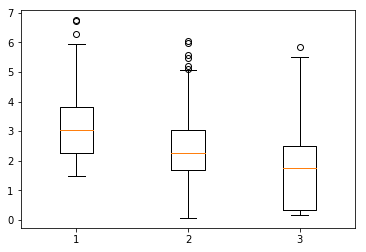

In [30]:
plt.boxplot([t0_list_clean,t0_list3_clean,t0cluster_list])

3.16908758428
2.46380120415
1.74425287356


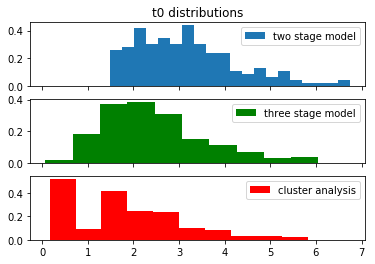

In [31]:
plt.figure()
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(3, sharex=True)
axarr[0].hist(t0_list_clean, bins=20,normed=True,label='two stage model')
axarr[0].set_title('t0 distributions')
axarr[0].legend()
axarr[1].hist(t0_list3_clean,bins=10,color='g',normed=True,label='three stage model')
axarr[1].legend()
axarr[2].hist(t0cluster_list,bins=10,color='r',normed=True,label='cluster analysis')
axarr[2].legend()
print(t0_list_clean.mean())
print(t0_list3_clean.mean())
print(t0cluster_list.mean())

In [32]:
# save data
np.save("k3_t0_two",t0_list_clean)
np.save("k3_t0_three",t0_list3_clean)
np.save("k3_t0_cluster",t0cluster_list)

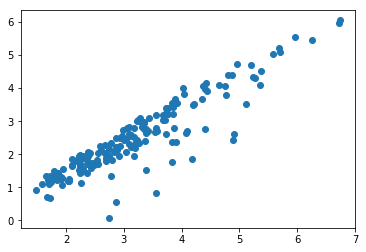

In [33]:
plt.plot(t0_list_clean,t0_list3_clean,"o")